# Kelas Apa yang Harus Saya Ikuti?

Model Rekomendasi Kelas Daring

Dataset yang digunakan adalah dataset dari sistem pembelajaran [Office 365 MOOC](https://dileap.com/en/) yang diselenggarakan oleh Mandarine Academy, University of Lille. Data diterbitkan tahun 2022 dan disimpan pada repositori [Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/BMY3UD).

Sitasi data:
Hafsa, M., Wattebled, P., Jacques, J., & Jourdan, L. (2023). E-learning recommender system dataset. Data in Brief, 47, 108942. https://doi.org/10.1016/j.dib.2023.108942

Sebagai catatan projek ini dikerjakan pada Google Colaboratory, semua *path* disesuaikan dengan spesifikasi pada Google Colaboratory.

## Pemerolehan Data

0. *Library Import* (ditambah sesuai kebutuhan)

In [1]:
!pip install scikit-learn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

1. Unggah data
2. Konversi data CSV ke dalam DataFrame

In [3]:
# Explicit Rating
explir = pd.read_csv("/content/explicit_ratings_en.csv")

# Implicit Rating
implir = pd.read_csv("/content/implicit_ratings_en.csv")

# Items
items = pd.read_csv("/content/items_en.csv")

# Users
users = pd.read_csv("/content/users_en.csv")

In [4]:
print("Data unik pada explicit rating: ", len(explir.user_id.unique()))
print("Data unik pada implicit rating: ", len(implir.user_id.unique()))
print("Data unik pada users: ", len(users.user_id.unique()))
print("Data unik items: ", len(items.item_id.unique()))
print("------------------------------------")
print("Total data explicit rating: ", len(explir))
print("Total data implicit rating: ", len(implir))
print("Total data users: ", len(users))
print("Total data items: ", len(items))

Data unik pada explicit rating:  822
Data unik pada implicit rating:  3007
Data unik pada users:  9902
Data unik items:  1167
------------------------------------
Total data explicit rating:  3659
Total data implicit rating:  21908
Total data users:  9902
Total data items:  1167


Melalui proses pembacaan total data dan data unik pada masing-masing variabel dapat disimpulkan beberapa poin:

* Seluruh isi variabel `users` dan `items` adalah unik.
* Data pada *explicit rating* dan *implicit rating* memiliki selisih antara total data *explicit rating* dan *explicit rating* per pengguna unik, sebagaimana juga terjadi pada *implicit rating*.

## Analisis Data Univariat

### Data `Users`

In [5]:
# Lima baris pertama
users.head()

,user_id,job
0,384,NaN
1,421,NaN
2,530,NaN
3,672,NaN
4,752,NaN


In [6]:
# Tipe data
users.dtypes

user_id     int64
job        object
dtype: object

In [7]:
# Job unik users
# Filter Job
users_filtered = users.dropna(subset=["job"])

# Tampilkan Job Unik Pengguna
unique_user_jobs = users_filtered["job"].unique()
print(unique_user_jobs)

['accounting' 'recherche et développement' 'communication' 'marketing'
 'marketing produit & service' 'finance, risk and insurance'
 'administrative' 'consulting' 'legal' 'ressources humaines'
 'production & logistique' 'it' 'achats' 'commercial' 'comptabilité'
 'conseil' 'general management' 'juridique' 'product & service marketing'
 'administratif' 'sales representative' 'direction générale'
 'finance & risque et assurance']


In [8]:
# Cek Nilai kosong
print("Null Value pada Dataframe:")
print(users.isnull().sum())

Null Value pada Dataframe:
user_id       0
job        8493
dtype: int64


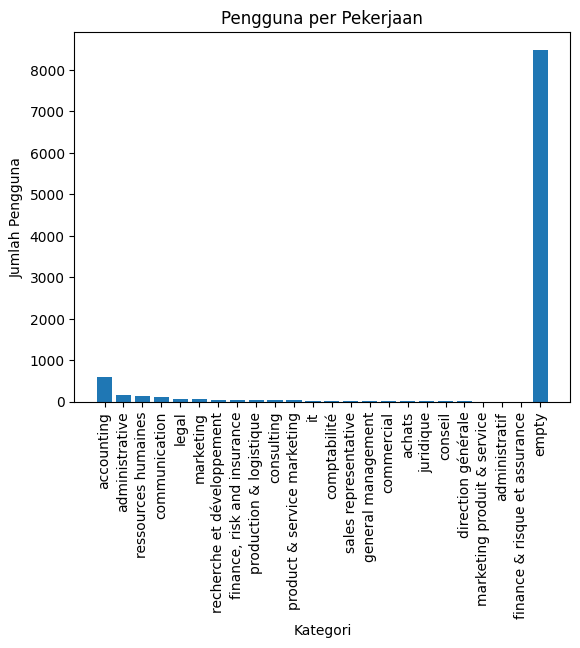

In [9]:
# Bar Chart perbandingan antara pekerjaan dan null value
# Hitung jumlah user pada tiap pekerjaan
job_counts = users["job"].value_counts()

# Assign nama "empty" sebagai pengganti NaN pada user yang tidak memiliki data job
job_counts["empty"] = users["job"].isnull().sum()

# Plot bagan
plt.bar(job_counts.index, job_counts.values)

# Tambah Label
plt.xlabel("Kategori")
plt.ylabel("Jumlah Pengguna")
plt.title("Pengguna per Pekerjaan")

# Kustomisasi x-axis
plt.xticks(rotation=90)

# Tampilkan
plt.show()

In [10]:
# Rincian pekerjaan pengguna

print("Kategori pekerjaan dan jumlah user teridentifikasi:")
for job, count in job_counts.items():
    print(f"{job}: {count}")

Kategori pekerjaan dan jumlah user teridentifikasi:
accounting: 603
administrative: 164
ressources humaines: 123
communication: 117
legal: 60
marketing: 56
recherche et développement: 50
finance, risk and insurance: 40
production & logistique: 37
consulting: 28
product & service marketing: 27
it: 25
comptabilité: 17
sales representative: 15
general management: 13
commercial: 10
achats: 7
juridique: 7
conseil: 3
direction générale: 3
marketing produit & service: 2
administratif: 1
finance & risque et assurance: 1
empty: 8493


Beberapa catatan yang dibuat dalam analisis ini:
1. Data pekerjaan (`job`) mayoritas tidak diisi
2. Data pekerjaan berbahasa Perancis, ditemukan beberapa redundansi makna

Karena mayoritas data null dan penelitian tidak mendukung penggunaan bahasa Perancis, fitur `job` akan di *drop*

### Data `Items`

In [11]:
items.head()

,item_id,language,name,nb_views,description,created_at,Difficulty,Job,Software,Theme,duration,type
0,510,en,What is OneDrive for Business?,1114.0,OneDrive for Businessis an online libraryto st...,2016,Beginner,[],['OneDrive'],['Discover'],42.0,tutorial
1,511,en,"Add, restore, delete documents on OneDrive",547.0,"To create a new document in OneDriveclick New,...",2016,Beginner,[],['OneDrive'],"['Share', 'Produce', 'Organize']",122.0,tutorial
2,512,en,Share documents,607.0,"By default, all content is private, so you don...",2016,Beginner,[],['OneDrive'],"['Share', 'Collaborate']",176.0,tutorial
3,513,en,Recycle bin,278.0,"When you delete a file or afolder, OneDrive gi...",2016,Beginner,"['Accounting', 'Financial', 'Human resources',...",['OneDrive'],"['Produce', 'Organize']",46.0,tutorial
4,514,en,Sync OneDrive for Business to your computer (W...,312.0,The one drive synchronization application is a...,2016,Beginner,[],['OneDrive'],"['Produce', 'Organize']",163.0,tutorial


In [12]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   item_id      1167 non-null   int64  
 1   language     1167 non-null   object 
 2   name         1167 non-null   object 
 3   nb_views     1119 non-null   float64
 4   description  1009 non-null   object 
 5   created_at   1167 non-null   int64  
 6   Difficulty   475 non-null    object 
 7   Job          1167 non-null   object 
 8   Software     1167 non-null   object 
 9   Theme        1167 non-null   object 
 10  duration     1167 non-null   float64
 11  type         1167 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 109.5+ KB


In [13]:
# Create a copy of the original "items" DataFrame for preprocessing
items_processed = items.copy()

# Replace [] with the string "empty" in the "Job" column
items_processed["Job"] = items_processed["Job"].apply(lambda x: "empty" if x == '[]' else x)

# Function to remove square brackets and apostrophe signs
def remove_square_brackets_and_apostrophes(val):
    if isinstance(val, str):
        # Remove square brackets
        val = val.replace("[", "").replace("]", "")
        # Remove apostrophes
        val = val.replace("'", "")
    return val

# Apply the remove_square_brackets_and_apostrophes function to the "Job" column
items_processed["Job"] = items_processed["Job"].apply(remove_square_brackets_and_apostrophes)

# items_processed info
items_processed.info()

print("----------------------------------")

# Check for missing values again after handling the lists and multiple job values
print("Missing Values in Items Processed DataFrame:")
print(items_processed.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   item_id      1167 non-null   int64  
 1   language     1167 non-null   object 
 2   name         1167 non-null   object 
 3   nb_views     1119 non-null   float64
 4   description  1009 non-null   object 
 5   created_at   1167 non-null   int64  
 6   Difficulty   475 non-null    object 
 7   Job          1167 non-null   object 
 8   Software     1167 non-null   object 
 9   Theme        1167 non-null   object 
 10  duration     1167 non-null   float64
 11  type         1167 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 109.5+ KB
----------------------------------
Missing Values in Items Processed DataFrame:
item_id          0
language         0
name             0
nb_views        48
description    158
created_at       0
Difficulty     692
Job              0
Software 

In [14]:
# Bahasa yang digunakan item
print("Bahasa-bahasa unik pada tiap item:")
print(items["language"].unique())

print("------------------------------")

# Tingkat kesulitan
print("Tingkat kesulitan unik:")
print(items["Difficulty"].unique())

print("------------------------------")

# Jenis kursus
print("Tipe kursus unik:")
print(items["type"].unique())

print("------------------------------")

# Distribusi durasi kursus
print("Statistik durasi kursus")
print(items["duration"].describe())

print("------------------------------")

# Cek Nilai kosong
print("Null Value pada Dataframe:")
print(items.isnull().sum())

Bahasa-bahasa unik pada tiap item:
['en']
------------------------------
Tingkat kesulitan unik:
['Beginner' 'Intermediate' 'Advanced' nan]
------------------------------
Tipe kursus unik:
['tutorial' 'webcast' 'use_case']
------------------------------
Statistik durasi kursus
count    1167.000000
mean      179.500428
std       304.696860
min        19.000000
25%        76.000000
50%       115.000000
75%       175.000000
max      3442.000000
Name: duration, dtype: float64
------------------------------
Null Value pada Dataframe:
item_id          0
language         0
name             0
nb_views        48
description    158
created_at       0
Difficulty     692
Job              0
Software         0
Theme            0
duration         0
type             0
dtype: int64


In [15]:
items_processed.head()

,item_id,language,name,nb_views,description,created_at,Difficulty,Job,Software,Theme,duration,type
0,510,en,What is OneDrive for Business?,1114.0,OneDrive for Businessis an online libraryto st...,2016,Beginner,empty,['OneDrive'],['Discover'],42.0,tutorial
1,511,en,"Add, restore, delete documents on OneDrive",547.0,"To create a new document in OneDriveclick New,...",2016,Beginner,empty,['OneDrive'],"['Share', 'Produce', 'Organize']",122.0,tutorial
2,512,en,Share documents,607.0,"By default, all content is private, so you don...",2016,Beginner,empty,['OneDrive'],"['Share', 'Collaborate']",176.0,tutorial
3,513,en,Recycle bin,278.0,"When you delete a file or afolder, OneDrive gi...",2016,Beginner,"Accounting, Financial, Human resources, Projec...",['OneDrive'],"['Produce', 'Organize']",46.0,tutorial
4,514,en,Sync OneDrive for Business to your computer (W...,312.0,The one drive synchronization application is a...,2016,Beginner,empty,['OneDrive'],"['Produce', 'Organize']",163.0,tutorial


Beberapa catatan yang dibuat dalam analisis ini:

1. Seluruh *course* menggunakan bahasa Inggris (`en`)
2. Terdapat tiga tipe tingkat kesulitan (`Beginner`, `Intermediate`, `Advanced`) dan beberapa tidak memiliki definisi. Ini akan diatasi dengan menjadikan item yang tidak memiliki tingkat kesulitan menjadi `general`.
3. Terdapat tiga jenis *course*: `tutorial`, `webcast` dan `use_case`
4. Pada dataset ini, `job` memiliki nilai kosong, akan tetapi diisi dengan kurung siku `[]`, sehingga butuh dibersihkan.
5. Rata-rata durasi video 179 second (2 - 3 menit)
6. Beberapa video tidak memiliki *view*
7. Beberapa deskripsi kosong.


### Data `Explir` atau *Explicit Rating*

In [16]:
explir.head()

,user_id,item_id,watch_percentage,created_at,rating
0,224557,510,100,2018-09-28 16:18:29,10
1,224557,615,100,2018-09-28 16:22:22,10
2,224557,7680,100,2018-09-28 16:23:34,10
3,224293,510,100,2018-09-28 17:20:30,10
4,224293,515,100,2018-09-28 17:40:02,10


In [17]:
explir.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3659 entries, 0 to 3658
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           3659 non-null   int64 
 1   item_id           3659 non-null   int64 
 2   watch_percentage  3659 non-null   int64 
 3   created_at        3659 non-null   object
 4   rating            3659 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 143.1+ KB


In [18]:
# Rata-rata Watch Percentage
print("Statistik Watch Percentage:")
print(explir["watch_percentage"].describe())

print("-------------------------")

# Cek Null Value
print("Null Value:")
print(explir.isnull().sum())

Statistik Watch Percentage:
count    3659.000000
mean       84.390817
std        30.120331
min         0.000000
25%        91.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: watch_percentage, dtype: float64
-------------------------
Null Value:
user_id             0
item_id             0
watch_percentage    0
created_at          0
rating              0
dtype: int64


Beberapa catatan yang dibuat dalam analisis ini:

1. Pada data *explicit rating* tidak ada data kosong
2. Rata-rata presentasi menonton: 84%

### Data `Implir` atau *Implicit Rating*

In [19]:
implir.head()

,item_id,user_id,created_at
0,510,4287,2016-11-02 20:59:23
1,510,4287,2017-06-20 00:33:46
2,511,4287,2017-06-20 00:44:42
3,512,4287,2017-06-20 00:52:11
4,513,4287,2017-06-20 00:54:41


In [20]:
implir.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21908 entries, 0 to 21907
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   item_id     21908 non-null  int64 
 1   user_id     21908 non-null  int64 
 2   created_at  21908 non-null  object
dtypes: int64(2), object(1)
memory usage: 513.6+ KB


In [21]:
# Cek Nilai Kosong
print("Nilai Kosong pada Data Frame:")
print(implir.isnull().sum())

Nilai Kosong pada Data Frame:
item_id       0
user_id       0
created_at    0
dtype: int64


Dari analisis yang dilakukan, tidak ditemukan adanya permasalahan pada data `implir` atau *Implicit Rating*.

## Data Preprocessing

### Pembersihan Data dari Dataset `Items`

In [22]:
# Buat variabel baru
items_processed = items.copy()

In [23]:
items_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   item_id      1167 non-null   int64  
 1   language     1167 non-null   object 
 2   name         1167 non-null   object 
 3   nb_views     1119 non-null   float64
 4   description  1009 non-null   object 
 5   created_at   1167 non-null   int64  
 6   Difficulty   475 non-null    object 
 7   Job          1167 non-null   object 
 8   Software     1167 non-null   object 
 9   Theme        1167 non-null   object 
 10  duration     1167 non-null   float64
 11  type         1167 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 109.5+ KB


In [24]:
# Kolom Jobs
# Ganti kurung siku kosong dengan "empty"
items_processed["Job"] = items_processed["Job"].apply(lambda x: "empty" if x == '[]' else x)

# Fungsi menghapus tanda petik dan kurung siku
def remove_square_brackets_and_apostrophes(val):
    if isinstance(val, str):
        # Hapus kurung siku
        val = val.replace("[", "").replace("]", "")
        # Hapus petik
        val = val.replace("'", "")
    return val

items_processed["Job"] = items_processed["Job"].apply(remove_square_brackets_and_apostrophes)

In [25]:
# Kolom Software
# Hapus kurung siku dan petik atas pada software
def remove_square_brackets_and_apostrophes_from_software(val):
    if isinstance(val, str):
        # Hapus kurung siku
        val = val.replace("[", "").replace("]", "")
        # Hapus petik atas
        val = val.replace("'", "")
    return val

items_processed["Software"] = items_processed["Software"].apply(remove_square_brackets_and_apostrophes_from_software)

# Tampilkan entry dengan data lebih dari 1
software_with_multiple_entries = items_processed[items_processed["Software"].str.contains(",")]
print(software_with_multiple_entries["Software"])

43                                        Outlook, Groups
44                                        Outlook, Groups
215                      Office 365 portal, Office Online
230                                       OneDrive, Excel
235          Skype for Business, Yammer, Outlook, OneNote
237           Yammer, SharePoint (Classic Sites), Outlook
238                    Outlook, Groups, Excel, PowerPoint
239                           Yammer, PowerPoint, OneNote
240       SharePoint (Classic Sites), PowerPoint, OneNote
241     Skype for Business, Outlook, Word, SharePoint ...
242                  Skype for Business, Outlook, OneNote
243                   SharePoint (Classic Sites), Outlook
244            SharePoint (Classic Sites), Project Online
245                     SharePoint (Classic Sites), Excel
246           Skype for Business, Outlook, Project Online
248                                 Yammer, Office Online
258                                     Outlook, FindTime
259           

In [26]:
# Kolom Theme
# Fungsi menghapus petik dan kurung siku
def remove_square_brackets_and_apostrophes_from_theme(val):
    if isinstance(val, str):
        # Hapus kurung siku
        val = val.replace("[", "").replace("]", "")
        # Hapus petik
        val = val.replace("'", "")
    return val

items_processed["Theme"] = items_processed["Theme"].apply(remove_square_brackets_and_apostrophes_from_theme)

In [27]:
items_processed.head()

,item_id,language,name,nb_views,description,created_at,Difficulty,Job,Software,Theme,duration,type
0,510,en,What is OneDrive for Business?,1114.0,OneDrive for Businessis an online libraryto st...,2016,Beginner,empty,OneDrive,Discover,42.0,tutorial
1,511,en,"Add, restore, delete documents on OneDrive",547.0,"To create a new document in OneDriveclick New,...",2016,Beginner,empty,OneDrive,"Share, Produce, Organize",122.0,tutorial
2,512,en,Share documents,607.0,"By default, all content is private, so you don...",2016,Beginner,empty,OneDrive,"Share, Collaborate",176.0,tutorial
3,513,en,Recycle bin,278.0,"When you delete a file or afolder, OneDrive gi...",2016,Beginner,"Accounting, Financial, Human resources, Projec...",OneDrive,"Produce, Organize",46.0,tutorial
4,514,en,Sync OneDrive for Business to your computer (W...,312.0,The one drive synchronization application is a...,2016,Beginner,empty,OneDrive,"Produce, Organize",163.0,tutorial


In [28]:
# Cek Nilai Kosong
print("Nilai Kosong pada Data Frame:")
print(items_processed.isnull().sum())

Nilai Kosong pada Data Frame:
item_id          0
language         0
name             0
nb_views        48
description    158
created_at       0
Difficulty     692
Job              0
Software         0
Theme            0
duration         0
type             0
dtype: int64


In [29]:
items_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   item_id      1167 non-null   int64  
 1   language     1167 non-null   object 
 2   name         1167 non-null   object 
 3   nb_views     1119 non-null   float64
 4   description  1009 non-null   object 
 5   created_at   1167 non-null   int64  
 6   Difficulty   475 non-null    object 
 7   Job          1167 non-null   object 
 8   Software     1167 non-null   object 
 9   Theme        1167 non-null   object 
 10  duration     1167 non-null   float64
 11  type         1167 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 109.5+ KB


### *Resolving Null Values*

#### `Nb_views`

Untuk mencegah bias yang akan terjadi bila nilai kosong pada `Items` di ubah menjadi 0, maka digunakan metode Imputasi menggunakan rata-rata.

In [30]:
# Perhitungan rata-rata data non-null pada nb_views
mean_nb_views = items_processed["nb_views"].mean()

# Menggantikan data null dengan rata-rata
items_processed["nb_views"].fillna(mean_nb_views, inplace=True)

# Periksa null_value
print("Null Value pada DataFrame:")
print(items_processed.isnull().sum())

Null Value pada DataFrame:
item_id          0
language         0
name             0
nb_views         0
description    158
created_at       0
Difficulty     692
Job              0
Software         0
Theme            0
duration         0
type             0
dtype: int64


In [31]:
items_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   item_id      1167 non-null   int64  
 1   language     1167 non-null   object 
 2   name         1167 non-null   object 
 3   nb_views     1167 non-null   float64
 4   description  1009 non-null   object 
 5   created_at   1167 non-null   int64  
 6   Difficulty   475 non-null    object 
 7   Job          1167 non-null   object 
 8   Software     1167 non-null   object 
 9   Theme        1167 non-null   object 
 10  duration     1167 non-null   float64
 11  type         1167 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 109.5+ KB


#### `Difficulty`

Karena *Null Value* pada data `difficulty` cukup besar (692 dari 1167 data), dan kolom tersebut merupakan data kategorikal, digunakan Imputasi dengan Model Machine Learning, untuk menentukan tingkat kesulitan pada data yang kosong berdasarkan fitur-fitur yang ada. Pada kasus ini, algoritma yang cocok digunakan adalah algoritma klasifikasi, yaitu, Algoritma Random Forest.

In [32]:
# Membuat salinan variable items
items_processed_imputed = items_processed.copy()

# One Hot Encoding pada data kategorikal
encoder = OneHotEncoder(drop='first', sparse=False)
type_encoded = encoder.fit_transform(items_processed_imputed[['type']])
type_encoded_df = pd.DataFrame(type_encoded, columns=[f'type_{i}' for i in range(type_encoded.shape[1])])

# Drop kolom type
items_processed_imputed.drop('type', axis=1, inplace=True)
items_processed_imputed = pd.concat([items_processed_imputed, type_encoded_df], axis=1)

# Data Preparation dengan y_train berisi data Difficulty yang Null
X_train = items_processed_imputed.loc[items_processed_imputed['Difficulty'].notnull(), ['nb_views', 'duration'] + type_encoded_df.columns.tolist()]
y_train = items_processed_imputed.loc[items_processed_imputed['Difficulty'].notnull(), 'Difficulty']

X_test = items_processed_imputed.loc[items_processed_imputed['Difficulty'].isnull(), ['nb_views', 'duration'] + type_encoded_df.columns.tolist()]

# Latih Model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Prediksi Null Value
predicted_difficulty = model.predict(X_test)

# Perbarui data pada items_processed_imputed
items_processed_imputed.loc[items_processed_imputed['Difficulty'].isnull(), 'Difficulty'] = predicted_difficulty


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [33]:
print(items_processed_imputed.isnull().sum())

item_id          0
language         0
name             0
nb_views         0
description    158
created_at       0
Difficulty       0
Job              0
Software         0
Theme            0
duration         0
type_0           0
type_1           0
dtype: int64


In [34]:
items_processed_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   item_id      1167 non-null   int64  
 1   language     1167 non-null   object 
 2   name         1167 non-null   object 
 3   nb_views     1167 non-null   float64
 4   description  1009 non-null   object 
 5   created_at   1167 non-null   int64  
 6   Difficulty   1167 non-null   object 
 7   Job          1167 non-null   object 
 8   Software     1167 non-null   object 
 9   Theme        1167 non-null   object 
 10  duration     1167 non-null   float64
 11  type_0       1167 non-null   float64
 12  type_1       1167 non-null   float64
dtypes: float64(4), int64(2), object(7)
memory usage: 118.6+ KB


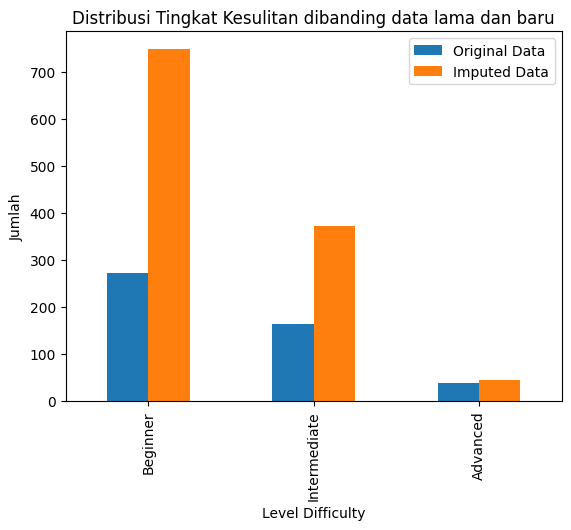

In [35]:
# Membuat diagram batang untuk perbandingan jumlah kursus per tingkat kesulitan
# Hitung berapa kali kemunculan tiap level kesulitan pada data lama
old_difficulty_counts = items_processed['Difficulty'].value_counts()

# Hitung berapa kali kemunculan tiap level kesulitan pada data baru
new_difficulty_counts = items_processed_imputed['Difficulty'].value_counts()

# Penggabungan
combined_counts = pd.concat([old_difficulty_counts, new_difficulty_counts], axis=1)
combined_counts.columns = ['Original Data', 'Imputed Data']

# Plotting diagram
combined_counts.plot(kind='bar')
plt.xlabel('Level Difficulty')
plt.ylabel('Jumlah')
plt.title('Distribusi Tingkat Kesulitan dibanding data lama dan baru')
plt.show()

In [36]:
# Pembaruan data pada variabel items_processed
items_processed.update(items_processed_imputed['Difficulty'])

In [37]:
# Cek
print(items_processed.isnull().sum())

item_id          0
language         0
name             0
nb_views         0
description    158
created_at       0
Difficulty       0
Job              0
Software         0
Theme            0
duration         0
type             0
dtype: int64


In [38]:
items_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   item_id      1167 non-null   int64  
 1   language     1167 non-null   object 
 2   name         1167 non-null   object 
 3   nb_views     1167 non-null   float64
 4   description  1009 non-null   object 
 5   created_at   1167 non-null   int64  
 6   Difficulty   1167 non-null   object 
 7   Job          1167 non-null   object 
 8   Software     1167 non-null   object 
 9   Theme        1167 non-null   object 
 10  duration     1167 non-null   float64
 11  type         1167 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 109.5+ KB


Karena sistem rekomendasi tidak menggunakan data Deskripsi yang berisi teks dan memiliki null values yang besar dan tidak bisa diisi dengan model secara sederhana, data deskripsi diabaikan.

Data *Implicit Ratings* dan *Explicit Rating* tidak memiliki Null Values, maka tidak melalui *data preprocessing*.

## Data Preparation

Untuk memudahkan proses *encoding* dan pelatihan model dilakukan penggabungan data.

### Data Merging

In [39]:
# Buat dataframe baru: prepared_cbf
prepared_cbf = pd.DataFrame()

# Masukan user_id, item_id dan rating dari explir
prepared_cbf['user_id'] = explir['user_id']
prepared_cbf['item_id'] = explir['item_id']
prepared_cbf['rating'] = explir['rating']

# Masukan data dari items_processed
item_attributes = items_processed[['item_id', 'duration', 'Difficulty', 'type']]
prepared_cbf = pd.merge(prepared_cbf, item_attributes, on='item_id', how='left')

In [40]:
prepared_cbf.head()

,user_id,item_id,rating,duration,Difficulty,type
0,224557,510,10,42.0,Beginner,tutorial
1,224557,615,10,57.0,Beginner,tutorial
2,224557,7680,10,72.0,Intermediate,tutorial
3,224293,510,10,42.0,Beginner,tutorial
4,224293,515,10,87.0,Beginner,tutorial


In [41]:
prepared_cbf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3659 entries, 0 to 3658
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_id     3659 non-null   int64  
 1   item_id     3659 non-null   int64  
 2   rating      3659 non-null   int64  
 3   duration    3659 non-null   float64
 4   Difficulty  3659 non-null   object 
 5   type        3659 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 200.1+ KB


In [42]:
print(prepared_cbf.isnull().sum())

user_id       0
item_id       0
rating        0
duration      0
Difficulty    0
type          0
dtype: int64


### *One-Hot Encoding* data CBF

*One hot encoding* berfungsi mengubah data kategorikal dan teks menjadi data numerik. Metode ini dipilih untuk mengubah data pada kolom `type` dan `Difficulty` menjadi data numerik agar dapat diproses oleh model *machine learning*. Data `Difficulty` dan `type` terdiri dari tiga kategori. Pada `Difficulty` terdiri dari `Beginner`, `Intermediate` dan `Advanced`. Data `type` terdiri dari `webcast`, `tutorial`, dan `use_case`. Karena jumlah kategori sedikit, metode *one hot encoding*.

In [43]:
# Encoding Type
one_hot_type = pd.get_dummies(prepared_cbf['type'], prefix='type')

# Encoding Difficulty
one_hot_difficulty = pd.get_dummies(prepared_cbf['Difficulty'], prefix='Difficulty')

# Pemindahan dengan melalukan Concatenate
prepared_cbf_encoded = pd.concat([prepared_cbf, one_hot_type, one_hot_difficulty], axis=1)

# Drop kolom type dan difficulty original
prepared_cbf_encoded.drop(['type', 'Difficulty'], axis=1, inplace=True)

In [44]:
prepared_cbf_encoded.head()

,user_id,item_id,rating,duration,type_tutorial,type_use_case,type_webcast,Difficulty_Advanced,Difficulty_Beginner,Difficulty_Intermediate
0,224557,510,10,42.0,1,0,0,0,1,0
1,224557,615,10,57.0,1,0,0,0,1,0
2,224557,7680,10,72.0,1,0,0,0,0,1
3,224293,510,10,42.0,1,0,0,0,1,0
4,224293,515,10,87.0,1,0,0,0,1,0


In [45]:
prepared_cbf_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3659 entries, 0 to 3658
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  3659 non-null   int64  
 1   item_id                  3659 non-null   int64  
 2   rating                   3659 non-null   int64  
 3   duration                 3659 non-null   float64
 4   type_tutorial            3659 non-null   uint8  
 5   type_use_case            3659 non-null   uint8  
 6   type_webcast             3659 non-null   uint8  
 7   Difficulty_Advanced      3659 non-null   uint8  
 8   Difficulty_Beginner      3659 non-null   uint8  
 9   Difficulty_Intermediate  3659 non-null   uint8  
dtypes: float64(1), int64(3), uint8(6)
memory usage: 164.4 KB


### *One-Hot Encoding* Data *Course Features* dan Feature Scaling

Untuk membuat *course embbeding* dibutuhkan *one_hot encoding* pada data `course_features`.

In [46]:
# Pilih kolom relevan
course_features = items_processed[['item_id', 'duration', 'Difficulty', 'type']]

# One-hot encoding untuk kolom  'Difficulty' dan 'type'
course_features_encoded = pd.get_dummies(course_features, columns=['Difficulty', 'type'], drop_first=False)

In [47]:
# Feature scaling dengan normalisai
scaler = MinMaxScaler()
numerical_features = ['duration', 'Difficulty_Advanced', 'Difficulty_Beginner', 'Difficulty_Intermediate',
                      'type_tutorial', 'type_use_case', 'type_webcast']

course_features_encoded[numerical_features] = scaler.fit_transform(course_features_encoded[numerical_features])

In [48]:
course_features_encoded.head()

,item_id,duration,Difficulty_Advanced,Difficulty_Beginner,Difficulty_Intermediate,type_tutorial,type_use_case,type_webcast
0,510,0.006719,0.0,1.0,0.0,1.0,0.0,0.0
1,511,0.030091,0.0,1.0,0.0,1.0,0.0,0.0
2,512,0.045866,0.0,1.0,0.0,1.0,0.0,0.0
3,513,0.007888,0.0,1.0,0.0,1.0,0.0,0.0
4,514,0.042068,0.0,1.0,0.0,1.0,0.0,0.0


### Membuat `User Profile`

In [49]:
# Grup data user
user_profiles = prepared_cbf_encoded.groupby('user_id').mean().reset_index()

# Menghilangkan kolom yang tidak dipakai
user_profiles = user_profiles.drop(['item_id', 'rating'], axis=1)

In [50]:
user_profiles.head()

,user_id,duration,type_tutorial,type_use_case,type_webcast,Difficulty_Advanced,Difficulty_Beginner,Difficulty_Intermediate
0,672,83.0,1.0,0.0,0.0,0.0,1.0,0.0
1,856,68.0,1.0,0.0,0.0,0.0,1.0,0.0
2,3928,153.0,1.0,0.0,0.0,0.0,1.0,0.0
3,4160,42.0,1.0,0.0,0.0,0.0,1.0,0.0
4,4448,103.0,1.0,0.0,0.0,0.0,1.0,0.0


In [51]:
user_profiles.tail()

,user_id,duration,type_tutorial,type_use_case,type_webcast,Difficulty_Advanced,Difficulty_Beginner,Difficulty_Intermediate
817,607339,238.5,1.0,0.0,0.0,1.0,0.0,0.0
818,607825,203.0,0.0,1.0,0.0,0.0,1.0,0.0
819,608098,80.0,1.0,0.0,0.0,0.0,1.0,0.0
820,608559,102.5,1.0,0.0,0.0,0.0,1.0,0.0
821,610262,150.5,0.5,0.5,0.0,0.0,1.0,0.0


In [52]:
user_profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822 entries, 0 to 821
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  822 non-null    int64  
 1   duration                 822 non-null    float64
 2   type_tutorial            822 non-null    float64
 3   type_use_case            822 non-null    float64
 4   type_webcast             822 non-null    float64
 5   Difficulty_Advanced      822 non-null    float64
 6   Difficulty_Beginner      822 non-null    float64
 7   Difficulty_Intermediate  822 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 51.5 KB


In [53]:
items_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   item_id      1167 non-null   int64  
 1   language     1167 non-null   object 
 2   name         1167 non-null   object 
 3   nb_views     1167 non-null   float64
 4   description  1009 non-null   object 
 5   created_at   1167 non-null   int64  
 6   Difficulty   1167 non-null   object 
 7   Job          1167 non-null   object 
 8   Software     1167 non-null   object 
 9   Theme        1167 non-null   object 
 10  duration     1167 non-null   float64
 11  type         1167 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 109.5+ KB


## Pemodelan *Content Based Filtering*

Pada tahap ini dilakukan filter berbasis konten.

### Pengukuran Similaritas

In [54]:
# Embedding pada user_profile
user_profiles_array = user_profiles.drop('user_id', axis=1).values

# Embedding pada course_features
course_embeddings_array = course_features_encoded.drop('item_id', axis=1).values

# Cosine Similarity antara course_embedding dan user_profile embedding
similarity_scores = cosine_similarity(user_profiles_array, course_embeddings_array)

### Pembuatan Rekomendasi

In [57]:
# Fungsi rekomendasi
def generate_user_recommendations(user_id, num_recommendations):
    # Karena user_id di drop, mencari padanan index pada row user_id dan user_profile
    try:
        user_row_index = user_profiles[user_profiles['user_id'] == user_id].index[0]
    except IndexError:
        print("Invalid user_id. User ID not found.")
        return None

    # Get similarity score
    user_similarity_scores = similarity_scores[user_row_index]

    # Top N course sesuai permintaan
    top_course_indices = np.argsort(user_similarity_scores)[::-1][:num_recommendations]

    # Pengambilan id untuk course yang terdapat pada rekomendasi
    top_course_ids = course_features_encoded.iloc[top_course_indices]['item_id']

    # Map id pada nama kursus
    recommended_courses = items_processed[items_processed['item_id'].isin(top_course_ids)]['name']

    return recommended_courses

In [58]:
# masukkan variabel id disini, cek pada user_profile untuk user_id yang tersedia
# masukkan jumlah rekomendasi

user_id = 608559
num_recommendations = 10
user_recommendations = generate_user_recommendations(user_id, num_recommendations)
print(user_recommendations)

197             How to communicate: who can help me?
199                How to search: find what you need
205      Office 2016 - new features and enhancements
249                Uses by job role: Human resources
250                   Uses by job role: Assistant(s)
251    Uses by job role: Marketing and communication
585                    Teams - Collaborate as a team
586                    Teams - Communicate as a team
773                Run effective meetings with Teams
835                     Discover the note taking app
Name: name, dtype: object
